# Confusion Matrix

* Module Name: confusion.ipynb
* Description: generate confusion matrix

Copyright (C) 2025 J.Cincotta

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program. If not, see <https://www.gnu.org/licenses/>.


In [1]:
from pyarrow import timestamp
from welfareobs.detectron.detectron_configuration import get_configuration
from welfareobs.detectron.detectron_calls import image_tensor, predict
from welfareobs.detectron.welfareobs_dataset import WelfareObsDataset
from detectron2.config import instantiate
from detectron2.checkpoint import DetectionCheckpointer
from welfareobs.handlers.abstract_handler import AbstractHandler
from welfareobs.models.frame import Frame
from welfareobs.models.individual import Individual
from welfareobs.utils.config import Config
from welfareobs.utils.bgr_transform import BGRTransform 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import os
import itertools
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss, roc_auc_score, accuracy_score
from sklearn.exceptions import ConvergenceWarning
import warnings



In [29]:
"""
Notebook configuration parameters:
"""
config_name = "config/detection-wod-md.json" # used in the pipelines
num_images = 2000 # total number of images to load
batch_size = 250 # batch size (tuned for the GPU)


In [30]:
"""
Load up the configuration
"""

cnf: Config = Config(config_name)
dimensions = cnf.as_int("dimensions")
reid_model_root = cnf.as_string("reid-model-root")
reid_timm_backbone = cnf.as_string("reid-timm-backbone")
segmentation_checkpoint = cnf.as_string("segmentation-checkpoint")
print("Configuration set")

Configuration set


In [31]:
"""
Load the model
"""


print(f"Reading model {reid_model_root}.")
model = instantiate(
    get_configuration(
        reid_model_root,
        backbone=reid_timm_backbone,
        dimensions=dimensions
    )
)
# then load it with the pretrained backbone
DetectionCheckpointer(model).load(segmentation_checkpoint)
model.eval()
model = model.to("cuda")


Reading model /project/data/results/wod-md.


In [32]:
"""
Load the dataset for evaluation
"""


dataset=WelfareObsDataset(
    root="/project/data/wod_reid",
    annotations_file="coco_train.json",   # change this to test against the training data
    transform = T.Compose([
        T.PILToTensor(), # Convert a PIL Image or ndarray to tensor and scale the values 0->255 to 0.0->1.0
        T.Resize(
            size=(dimensions,dimensions),
            interpolation=T.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True
        ),
        # note that we do NOT normalise the image because that is happening inside Detectron2
        BGRTransform()  # since our data source is RGB
        # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]),
    img_load="bbox", # "bbox_mask",
    col_path="path",
    col_label="identity",
    load_label=True
)




In [33]:
"""
Dump image sample (only works for small values of num_images)
"""
# fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(10, 10*num_images))
# for index, (item, ax) in enumerate(zip(itertools.islice(dataset, num_images),axs)):
#     ax.imshow(np.array(item[0]).transpose(1, 2, 0)[ :, : ,[2, 1, 0]])  # 
#     ax.axis('off')


'\nDump image sample (only works for small values of num_images)\n'

In [34]:
known_classes = []
prediction_classes = []

subset = itertools.islice(dataset, num_images)
for i in range(0, num_images, batch_size):
    image_tensors = []
    print(f"Batch {i/batch_size}")
    for item in itertools.islice(subset, batch_size):
        image_tensors.append(item[0])
        known_classes.append(dataset.labels_map[item[1]])
    torch.cuda.empty_cache()
    if len(image_tensors) > 0:
        output = predict(image_tensors, model)
        for index, item in enumerate(output):
            item = item["instances"]
            step_result = 0
            if item.has("reid_embeddings"):
                _reids = list(item.get("reid_embeddings").cpu().numpy().flatten())
                _scores = list(item.get("scores").cpu().numpy())
                for i in range(len(item)):
                    if _reids[i] != -1:
                        step_result = _reids[i]
            prediction_classes.append(step_result)


Batch 0.0
Batch 1.0
Batch 2.0
Batch 3.0
Batch 4.0
Batch 5.0
Batch 6.0
Batch 7.0


In [35]:
#    print(f"{index} {known_classes[index]==prediction_classes[index]} {known_classes[index]} {prediction_classes[index]}")

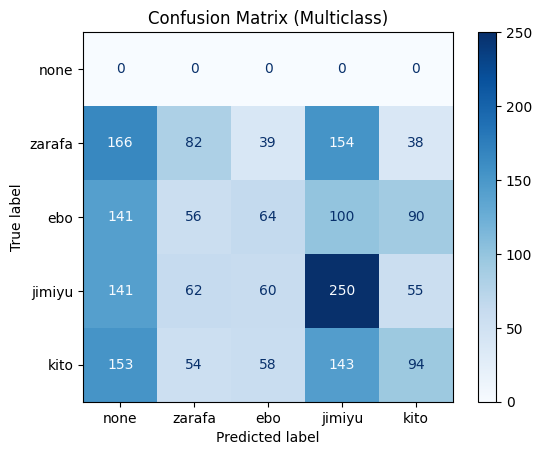

In [36]:
# Generate and display the confusion matrix
cm = confusion_matrix(known_classes, prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["none", "zarafa", "ebo", "jimiyu", "kito"])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()


In [37]:
accuracy = accuracy_score(known_classes, prediction_classes)
print(f"Accuracy: {accuracy:.4f}")

classification_report(known_classes, prediction_classes,output_dict=True)


Accuracy: 0.2450


/usr/local/lib/python3.13/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.13/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.13/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '1': {'precision': 0.3228346456692913,
  'recall': 0.17118997912317327,
  'f1-score': 0.22373806275579808,
  'support': 479.0},
 '2': {'precision': 0.2895927601809955,
  'recall': 0.1419068736141907,
  'f1-score': 0.19047619047619047,
  'support': 451.0},
 '3': {'precision': 0.38639876352395675,
  'recall': 0.44014084507042256,
  'f1-score': 0.411522633744856,
  'support': 568.0},
 '4': {'precision': 0.33935018050541516,
  'recall': 0.18725099601593626,
  'f1-score': 0.24133504492939667,
  'support': 502.0},
 'accuracy': 0.245,
 'macro avg': {'precision': 0.26763526997593173,
  'recall': 0.1880977387647446,
  'f1-score': 0.21341438638124824,
  'support': 2000.0},
 'weighted avg': {'precision': 0.3375362092062727,
  'recall': 0.245,
  'f1-score': 0.2739851712432122,
  'support': 2000.0}}